# 02 - Data from the Web

First, we make the necessary imports...

In [1]:
import pandas as pd
import numpy as np
import requests as rq
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup as bs

import seaborn as sns

%matplotlib inline

## Question 1

Obtain the 200 top-ranking universities in [www.topuniversities.com](http://www.topuniversities.com/) ([ranking 2018](https://www.topuniversities.com/university-rankings/world-university-rankings/2018)). In particular, extract the following fields for each university: name, rank, country and region, number of faculty members (international and total) and number of students (international and total). Some information is not available in the main list and you have to find them in the [details page](https://www.topuniversities.com/universities/ecole-polytechnique-fédérale-de-lausanne-epfl).
Store the resulting dataset in a pandas DataFrame and answer the following questions:
  - Which are the best universities in term of: (a) ratio between faculty members and students, (b) ratio of international students?
  - Answer the previous question aggregating the data by (c) country and (d) region.

Plot your data using bar charts and describe briefly what you observed.

### Answer

After intercepting the requests made when loading [www.topuniversities.com](www.topuniversities.com), we found out that the Universities' list is retrieved via a text file: [https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt](https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt).

The aforementioned text file is in fact a JSON file.

We load it and we only keep the first 200 entries, which is trivial, because the data list is already sorted by ranking.

In [2]:
# load rankings data from topuniversities.com as a JSON file
rankings_url = 'https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt'
rankings = rq.get(rankings_url).json()

# university list is sorted by ranking, so keep only the first 200
top200_top = rankings['data'][:200]

`top200_top` above is a list of dictionaries, with each dictionary representing a University. Apart from interesting data (for us), these dictionaries also contain data we do not care about. Also they miss some data we will need for our analysis, i.e. the people numbers (staff+students).

So, the next step is to clean and complete this data.

In [3]:
# top200_top is a list of dicts, each dict representing a university
# for each dictionary, keep only the columns we need
columns_top = [
    'title',
    'rank_display',
    'country',
    'region',
    # these columns will be populated later
    'staff_total',
    'staff_international',
    'students_total',
    'students_international',
    'url',
]

for uni in top200_top:  # for each university
    for key in set(uni.keys()) - set(columns_top):  # for each key we are not interested in
        del uni[key]  # delete that key

# populate the last four columns
# first define a function to populate the columns for a given university
def populate_people_top(uni):
    """
    Given a university dict from topuniversities, populate the missing columns:
        - staff_total
        - staff_international
        - students_total
        - students_international
    
    Args:
        - uni (dict): a university entry from top200        
    """
    # desired div class
    source = ['total faculty', 'inter faculty', 'total student', 'total inter']
    # dict with values we want to update
    people = {'staff_total': None, 'staff_international': None, 'students_total': None, 'students_international': None}
    url = 'https://www.topuniversities.com' + uni['url']
    r = rq.get(url)
    soup = bs(r.content, 'html.parser')
    if soup:
        for s, k in zip(source, people.keys()):
            temp = soup.find('div', attrs={'class' : s})
            if temp:
                people[k] = int((temp.find('div', attrs={'class' : 'number'})).text.strip().replace(',', ''))
    uni.update(people)
    
# complete the data by populating the missing columns
for i, uni in enumerate(top200_top, start=1):
    populate_people_top(uni)
    print('. {:>3}'.format(i)) if i % 50 == 0 else print('.', end='')

..................................................  50
.................................................. 100
.................................................. 150
.................................................. 200


We now have the complete data that we need for our analysis. The next step is to load them into a `pandas` `DataFrame`.

This is pretty straight-forward in `pandas`:

In [4]:
top200_top_df = pd.DataFrame(top200_top, columns=columns_top)

`top200_top_df` is a `pandas` `DataFrame` containing the extracted information. We are now ready to answer the questions:

  - (a) Which are the best universities in term of the ratio between faculty members and students?
    
  - (b) Which are the best universities in term of the ratio of international students?
  
To answer this question, we first need to compute the ratios and then sort according to those ratios.

In [5]:
# compute the students/staff ratio for each university
students_per_staff = round(top200_top_df.students_total / top200_top_df.staff_total, 2)
top200_top_df['ratio_students_staff'] = students_per_staff
top200_top_df.sort_values('ratio_students_staff', axis=0 , ascending=True).head()

,title,rank_display,country,region,staff_total,staff_international,students_total,students_international,url,ratio_students_staff
3,California Institute of Technology (Caltech),4,United States,North America,953.0,350.0,2255.0,647.0,/universities/california-institute-technology-...,2.37
15,Yale University,16,United States,North America,4940.0,1708.0,12402.0,2469.0,/universities/yale-university,2.51
5,University of Oxford,6,United Kingdom,Europe,6750.0,2964.0,19720.0,7353.0,/universities/university-oxford,2.92
4,University of Cambridge,5,United Kingdom,Europe,5490.0,2278.0,18770.0,6699.0,/universities/university-cambridge,3.42
16,Johns Hopkins University,17,United States,North America,4462.0,1061.0,16146.0,4105.0,/universities/johns-hopkins-university,3.62


We outline the results in the following bar plot.

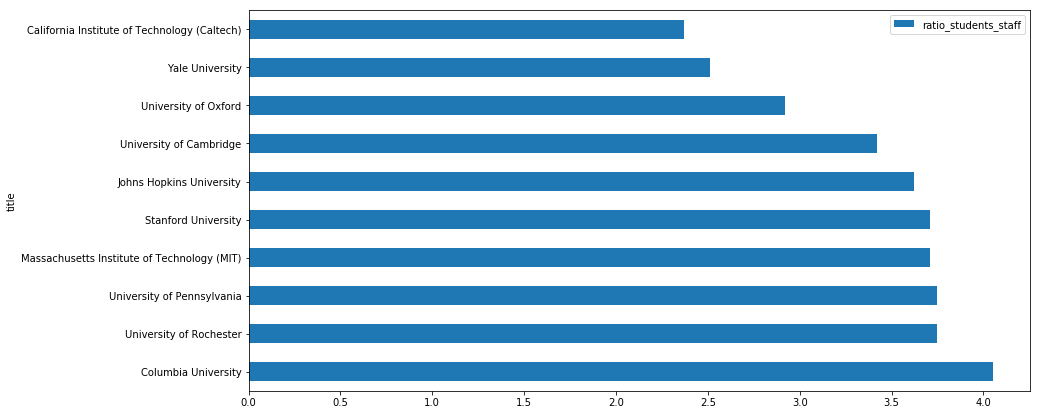

In [6]:
# we sort the ratio students staff ascending
h1 = top200_top_df.sort_values('ratio_students_staff').head(10)

h1.sort_values('ratio_students_staff', ascending=False).plot.barh(x='title',
    y=['ratio_students_staff'],
    figsize=(14, 7),
)

In [7]:
# compute the international/total students ratio for each university
ratio_international_students = top200_top_df.students_international / top200_top_df.students_total * 100
top200_top_df['ratio_international_students'] = ratio_international_students
top200_top_df.sort_values('ratio_international_students', axis=0 , ascending=False).head()

,title,rank_display,country,region,staff_total,staff_international,students_total,students_international,url,ratio_students_staff,ratio_international_students
34,London School of Economics and Political Scien...,35,United Kingdom,Europe,1088.0,687.0,9760.0,6748.0,/universities/london-school-economics-politica...,8.97,69.139344
11,Ecole Polytechnique Fédérale de Lausanne (EPFL),12,Switzerland,Europe,1695.0,1300.0,10343.0,5896.0,/universities/ecole-polytechnique-f%C3%A9d%C3%...,6.10,57.004738
7,Imperial College London,8,United Kingdom,Europe,3930.0,2071.0,16090.0,8746.0,/universities/imperial-college-london,4.09,54.356743
198,Maastricht University,200,Netherlands,Europe,1277.0,502.0,16385.0,8234.0,/universities/maastricht-university,12.83,50.253280
47,Carnegie Mellon University,=47,United States,North America,1342.0,425.0,13356.0,6385.0,/universities/carnegie-mellon-university,9.95,47.806229


We outline the results in the following bar plot.

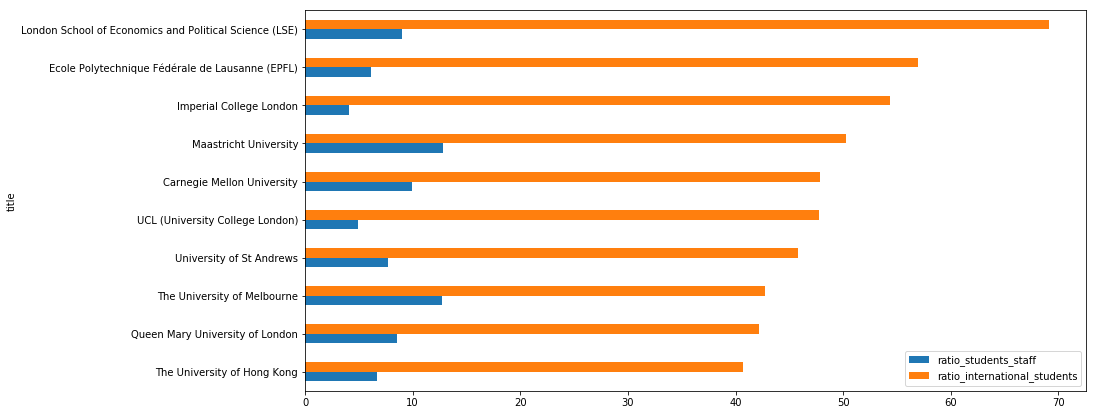

In [8]:
# we sort the ratio students staff ascending
h2 = top200_top_df.sort_values('ratio_international_students', axis=0 , ascending=False).head(10)

h2.sort_values('ratio_international_students', ascending=True).plot.barh(x='title',
    y=['ratio_students_staff', 'ratio_international_students'],
    figsize=(14, 7),
)

From the above plots we conclude that the universities with the highest ratio of international students
tend to have a very low ratio of students per staff, which is a good indication that the students' needs are satisfied more efficiently and at a greater extent.

Other than that, universities with lower students staff (faculty) ratio and higher ratio of international students,
come from rich countries (US, Switzerland, UK) which presumably spend money on (higher) education and depend on this ratio to attract students.

##### We can also plot the data by aggregating by country and by region.

We want to see how each country or region does in the students to staff and international students ratio.

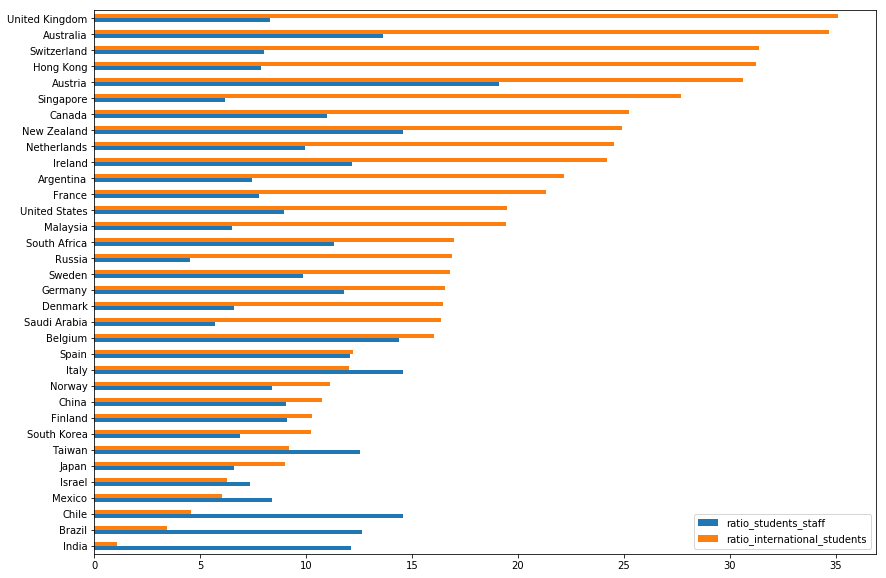

In [9]:
h3_1 = top200_top_df.groupby('country')['ratio_students_staff'].mean().sort_values(ascending=True)

h3_2 = top200_top_df.groupby('country')['ratio_international_students'].mean().sort_values(ascending=False)

country_ratio = pd.concat([h3_1, h3_2], axis=1)
country_ratio.sort_values('ratio_international_students').plot.barh(
    figsize=(14, 10),
)

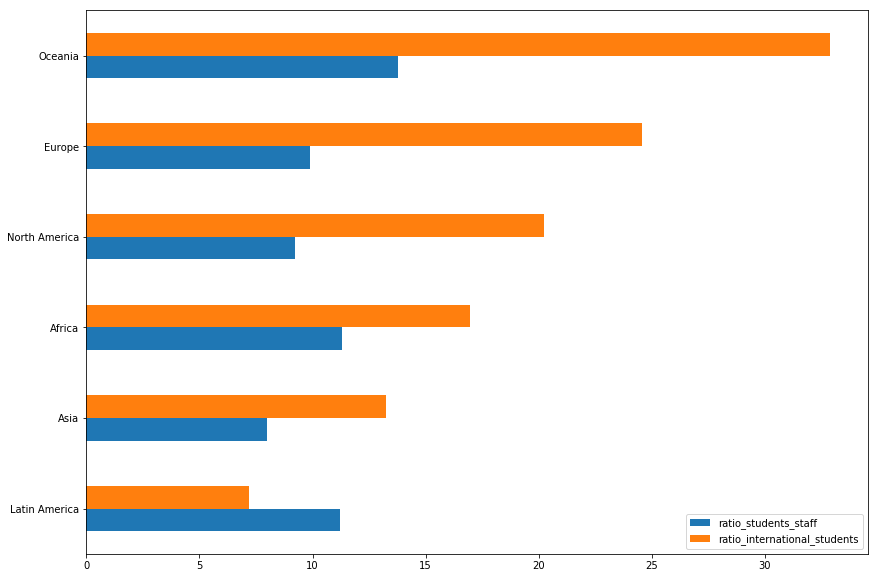

In [10]:
h3_1 = top200_top_df.groupby('region')['ratio_students_staff'].mean().sort_values(ascending=False)

h3_2 = top200_top_df.groupby('region')['ratio_international_students'].mean().sort_values(ascending=False)

region_ratio = pd.concat([h3_1, h3_2], axis=1)
region_ratio.sort_values('ratio_international_students').plot.barh(
    figsize=(14, 10),
)

We can make two observations:
1. Oceania has the highest international students ratio but also has the worst student-to-staff ratio. The first is due to the very few countries that are in Oceania, in essence Australia and New Zealand.
2. There seem to be several conditions that attract international students:
    * The programme is in English and the former is a language widely spoken in the country: the UK is first and all countries at the top positions satisfy this condition.
    * If a country offers decent programmes and is in a region which is far from the so-called "popular" countries (e.g. Europe, US) then it seems likely to attract students from neighboring countries. Such examples are Australia, Hong Kong and Argentina, which exhibit high ratio of international students.

We proceed to find the best universities by aggregating the data by:
  - (c) country
  - (d) region

In [11]:
rank_country = top200_top_df[['title', 'country']].groupby('country').count() \
                    .rename(columns={'title': 'count'}) \
                    .sort_values(by='count', ascending=False)
rank_country.head(10)

,count
country,
United States,47
United Kingdom,28
Germany,11
Netherlands,10
Australia,9
Japan,9
Canada,7
Switzerland,7
South Korea,7


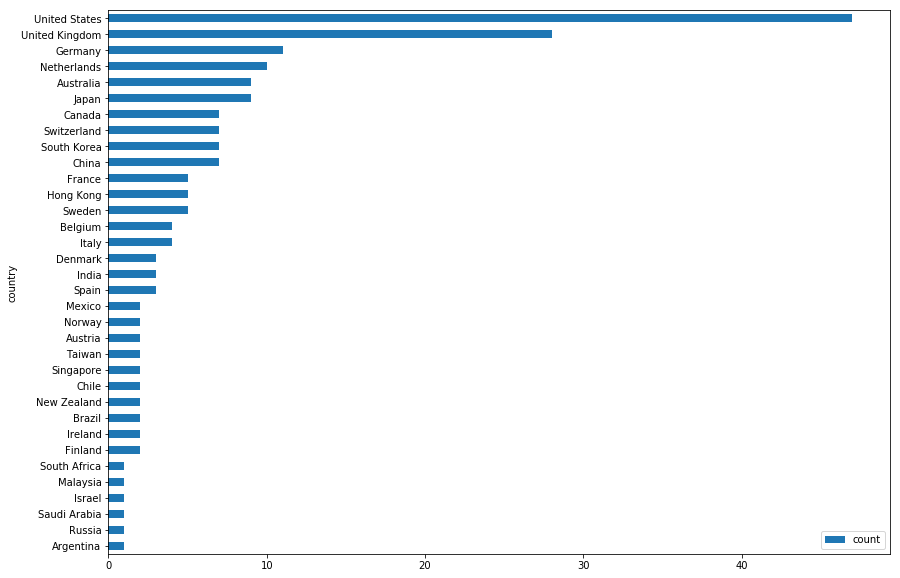

In [12]:
rank_country.sort_values('count', ascending=True).plot.barh(
    figsize=(14, 10),
)

In [13]:
rank_region = top200_top_df[['title', 'region']].groupby('region').count() \
                    .rename(columns={'title': 'count'}) \
                    .sort_values(by='count', ascending=False)
rank_region

,count
region,
Europe,89
North America,54
Asia,38
Oceania,11
Latin America,7
Africa,1


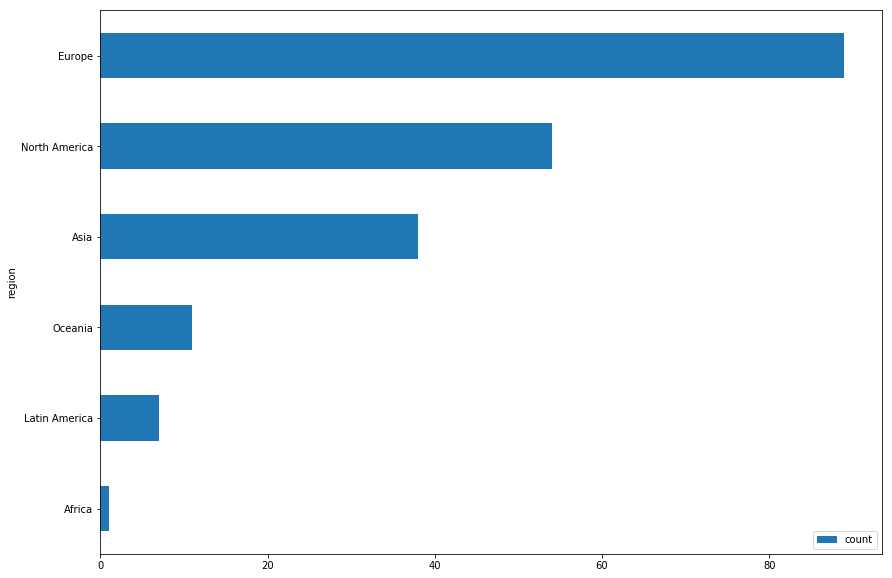

In [14]:
rank_region.sort_values('count', ascending=True).plot.barh(
    figsize=(14, 10),
)

In particular, it would be interesting to check how the number of top Universites per region relates to the ratios.

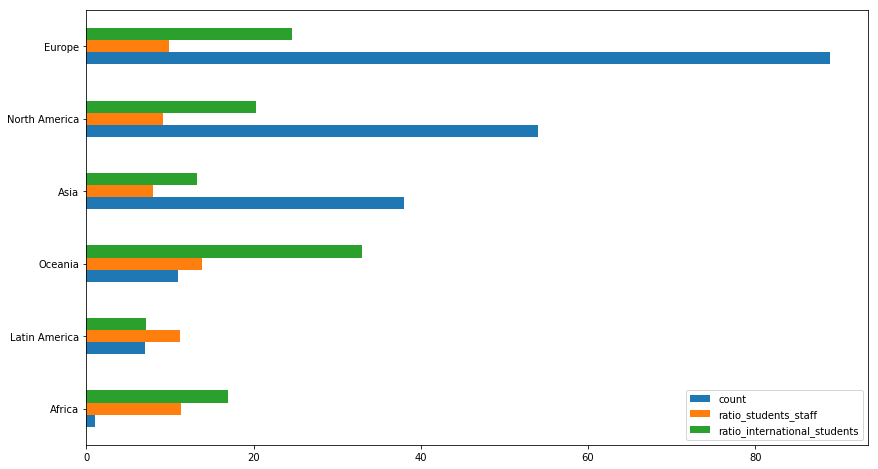

In [15]:
pd.concat([rank_region, region_ratio], axis=1).sort_values('count').plot.barh(
    figsize=(14, 8),
)

Here we can observe that there is a quite strong relation between how many Universities from a given region are at the top-200 and the mean of the ratio of the international students. This is excepted, as top Universities, attract more students from abroad.

## Question 2

Obtain the 200 top-ranking universities in [www.timeshighereducation.com](http://www.timeshighereducation.com/) ([ranking 2018](http://timeshighereducation.com/world-university-rankings/2018/world-ranking)). Repeat the analysis of the previous point and discuss briefly what you observed.


### Answer

We repeat the above analysis for [www.timeshighereducation.com](http://www.timeshighereducation.com/).

After intercepting the requests made when loading [www.timeshighereducation.com](http://www.timeshighereducation.com/), we found out that the rankings are retrieved via a JSON file.

In [16]:
# load rankings data from timeshighereducation.com as a JSON file
rankings_url = 'https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json'
rankings = rq.get(rankings_url).json()

# university list is sorted by ranking, so keep only the first 200
top200_times = rankings['data'][:200]

`top200_times` above is a list of dictionaries, with each dictionary representing a University. Apart from interesting data (for us), these dictionaries also contain data we do not care about. Also they miss some data we will need for our analysis, i.e. the people numbers (staff+students).

So, the next step is to clean and complete this data.

In [17]:
import locale
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')

# top200_times is a list of dicts, each dict representing a university
# for each dictionary, keep only the columns we need
columns_times = [
    'name',
    'rank',
    'location',
    # to be populated later
    'region',
    'staff_total',
    'staff_international',
    'students_total',
    'students_international',
    # keeping them just in case
    'stats_number_students',
    'stats_pc_intl_students',
    'stats_student_staff_ratio',
]

for uni in top200_times:  # for each university
    for key in set(uni.keys()) - set(columns_times):  # for each key we are not interested in
        del uni[key]  # delete that key

# populate the last four columns
# first define a function to populate the columns for a given university
def populate_people_times(uni):
    """
    Given a university dict from timeshighereducation.com, populate the missing columns:
        - staff_total
        - staff_international
        - students_total
        - students_international
    
    Args:
        - uni (dict): a university entry from top200        
    """
    # desired div class
    source = ['total faculty', 'inter faculty', 'total student', 'total inter']
    # dict with values we want to update
    people = {'staff_total': None, 'staff_international': None, 'students_total': None, 'students_international': None}
    # first, "normalise" some of the existing columns
    uni['stats_number_students'] = locale.atoi(uni['stats_number_students'])
    uni['stats_pc_intl_students'] = float(uni['stats_pc_intl_students'].strip().replace('%', ''))
    uni['stats_student_staff_ratio'] = float(uni['stats_student_staff_ratio'])
    # calculate and populate staff_total
    people['staff_total'] = int(uni['stats_number_students'] / uni['stats_student_staff_ratio'])
    # calculate and populate staff_international
    # TODO
    # calculate and populate students_total
    people['students_total'] = uni['stats_number_students']
    # calculate and populate students_international
    people['students_international'] = int(uni['stats_number_students'] * (uni['stats_pc_intl_students'] / 100.0))
    uni.update(people)
    
# complete the data by populating the missing columns
for i, uni in enumerate(top200_times, start=1):
    populate_people_times(uni)
    print('. {:>3}'.format(i)) if i % 50 == 0 else print('.', end='')

..................................................  50
.................................................. 100
.................................................. 150
.................................................. 200


We still need to populate one missing field for the Universities from timeshighereducation.com and that is the region. We will use the data from topuniversities to our advantage.

We first construct a dictionary containing the `country:region` mappings for the Universities from topuniversities.com. Then we consult this dictionary in order to populate the region for timeshighereducation.com.

In [18]:
# region map - Luxembourg missing from the
# topuniversities.com universities list
region_map = {
    'Luxembourg': 'Europe',
}

# consult the list from topuniversities.com to complete the region map
for uni in top200_top:
    region_map[uni['country']] = uni['region']

# replace any occurence of "Russian Federation" in
# timeshighereducation.com dataset with "Russia"
for uni in top200_times:
    if uni['location'] == "Russian Federation":
        uni['location'] = "Russia"

# populate the region column
for uni in top200_times:
    uni['region'] = region_map[uni['location']]

We now load the above list into a `pandas` `DataFrame`.

In [19]:
top200_times_df = pd.DataFrame(top200_times, columns=columns_times)

`top200_times_df` is a `pandas` `DataFrame` containing the extracted information. We are now ready to answer the questions:

  - (a) Which are the best universities in term of the ratio between faculty members and students?
    
  - (b) Which are the best universities in term of the ratio of international students?
  
To answer this question, we first need to compute the ratios and then sort according to those ratios.

The first question is already answered, as the data is provided by the website. We just need to rename the column for consistency.

In [20]:
# students/staff ratio already available, rename column for consistency
top200_times_df.rename(columns={'stats_student_staff_ratio': 'ratio_students_staff'}, inplace=True)
top200_times_df.sort_values('ratio_students_staff', axis=0 , ascending=True).head()

,name,rank,location,region,staff_total,staff_international,students_total,students_international,stats_number_students,stats_pc_intl_students,ratio_students_staff
105,Vanderbilt University,=105,United States,North America,3639,None,12011,1561,12011,13.0,3.3
109,University of Copenhagen,=109,Denmark,Europe,7413,None,30395,4255,30395,14.0,4.1
12,Johns Hopkins University,13,United States,North America,3604,None,15498,3719,15498,24.0,4.3
11,Yale University,12,United States,North America,2826,None,12155,2552,12155,21.0,4.3
153,University of Rochester,=153,United States,North America,2240,None,9636,2794,9636,29.0,4.3


We outline the results in the following bar plot.

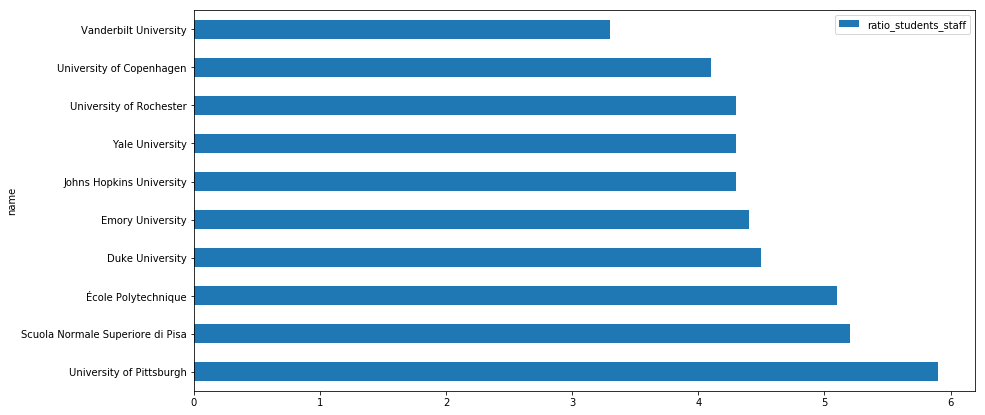

In [21]:
# we sort the ratio students staff ascending
h1 = top200_times_df.sort_values('ratio_students_staff', axis=0 , ascending=True).head(10)

h1.sort_values('ratio_students_staff', ascending=False).plot.barh(x='name',
    y=['ratio_students_staff'],
    figsize=(14, 7),
)

In [22]:
# compute the international/total students ratio for each university
ratio_international_students = top200_times_df.students_international / top200_times_df.students_total * 100
top200_times_df['ratio_international_students'] = ratio_international_students
top200_times_df.sort_values('ratio_international_students', axis=0 , ascending=False).head()

,name,rank,location,region,staff_total,staff_international,students_total,students_international,stats_number_students,stats_pc_intl_students,ratio_students_staff,ratio_international_students
24,London School of Economics and Political Science,=25,United Kingdom,Europe,825,None,10065,7146,10065,71.0,12.2,70.998510
178,University of Luxembourg,=179,Luxembourg,Europe,340,None,4969,2832,4969,57.0,14.6,56.993359
7,Imperial College London,8,United Kingdom,Europe,1390,None,15857,8721,15857,55.0,11.4,54.997793
37,École Polytechnique Fédérale de Lausanne,=38,Switzerland,Europe,886,None,9928,5460,9928,55.0,11.2,54.995971
102,Maastricht University,103,Netherlands,Europe,929,None,16727,8363,16727,50.0,18.0,49.997011


We outline the results in the following bar plot.

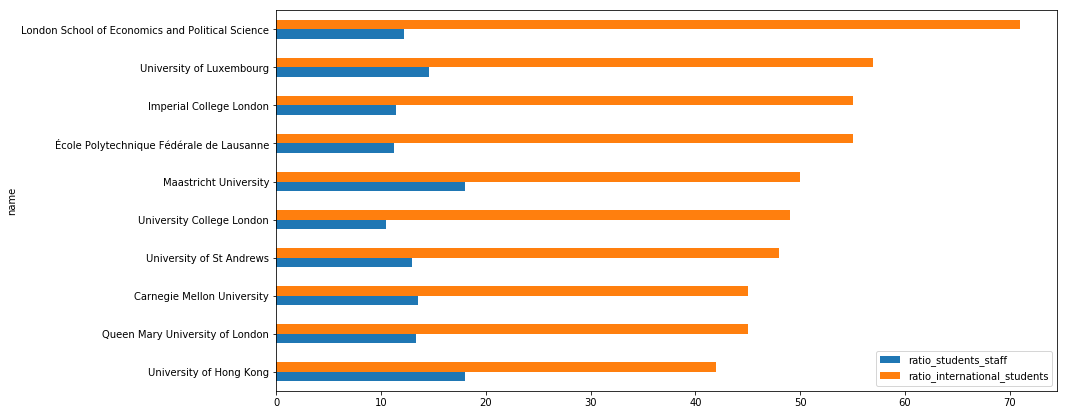

In [23]:
# we sort the ratio students staff ascending
h2 = top200_times_df.sort_values('ratio_international_students', axis=0 , ascending=False).head(10)

h2.sort_values('ratio_international_students', ascending=True).plot.barh(x='name',
    y=['ratio_students_staff', 'ratio_international_students'],
    figsize=(14, 7),
)

What we observe here, is that the results (in terms of Universities which occupy the first places) are almost completely different from the results that we obtained with the topuniversities.com datasets, which can possibly be attributed to the way each provider measures these counts. 

Another explanation could be approximations. The ratios from topuniversities.com had to be manually computed by us, whereas the ratios from timeshighereducation.com were already given and we had to compute the counts. This explains the above situation quite well.

##### We can also plot the data by aggregating by country and by region.

We want to see how each country or region does in the students to staff and international students ratio.

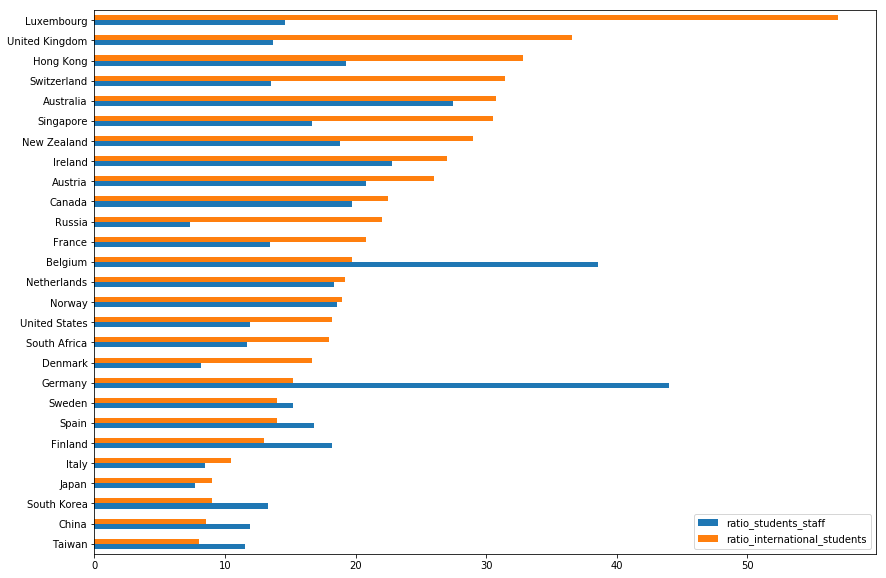

In [24]:
h3_1 = top200_times_df.groupby('location')['ratio_students_staff'].mean().sort_values(ascending=True)

h3_2 = top200_times_df.groupby('location')['ratio_international_students'].mean().sort_values(ascending=False)

country_ratio = pd.concat([h3_1, h3_2], axis=1)
country_ratio.sort_values('ratio_international_students').plot.barh(
    figsize=(14, 10),
)

What we can immediately spot on the bar chart above is the disturbingly high students-per-staff ratio for Universities of Belgium and Germany. This is unlikely to be a result of wrong calculations on our side, as the ratio comes directly from timeshighereducation.com.

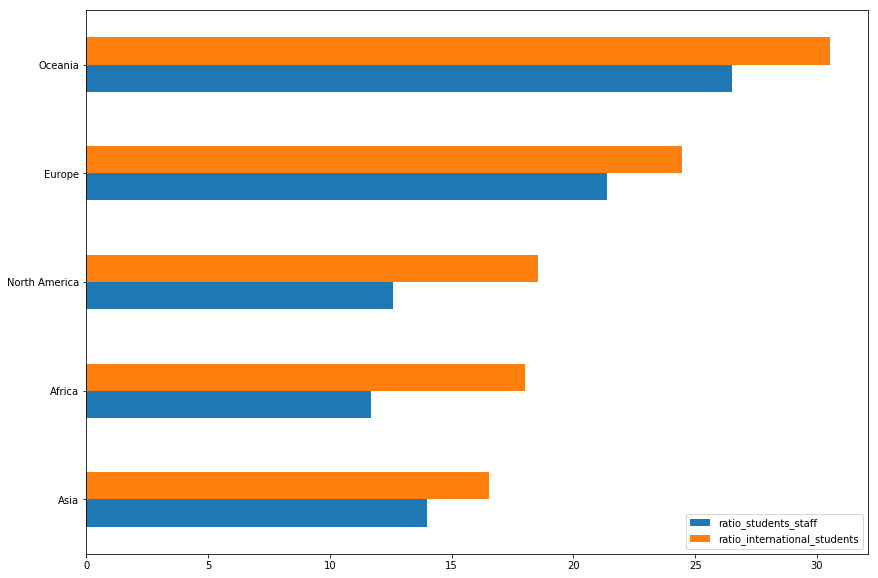

In [25]:
h3_1 = top200_times_df.groupby('region')['ratio_students_staff'].mean().sort_values(ascending=False)

h3_2 = top200_times_df.groupby('region')['ratio_international_students'].mean().sort_values(ascending=False)

region_ratio = pd.concat([h3_1, h3_2], axis=1)
region_ratio.sort_values('ratio_international_students').plot.barh(
    figsize=(14, 10),
)

Our observations about the popularity among international students agree with the ones made for the topuniversities.com dataset.

A very important observation however, is that the timeshighereducation.com top-200 list does not contain any University from Latin America. From a quick search in the website, we found out that several Universities that appear in very good positions in topuniversities.com are ranked very poorly or completely missing from timeshighereducation.com.

As examples, take University of Buenos Aires in Argentina, which is ranked 75th in topuniversities.com but is missing from timeshighereducation.com and University of São Paulo, which is ranked 121st in topuniversities.com, but the timeshighereducation.com ranking places it in positions 251-300.

This could indicate a lack of data (or knowledge for their existence) regarding the aforemenioned Universities, or may even be a case of biased data.

On the other side, a new country entry, Luxemburg, appears because of the presence of the University of Luxemburg in the timeshighereducation.com dataset. Of course it easily occupies the first place, because of the country being really small and having a small population.

We proceed to find the best universities by aggregating the data by:
  - (c) country
  - (d) region

In [26]:
rank_country = top200_times_df[['name', 'location']].groupby('location').count() \
                    .rename(columns={'name': 'count'}) \
                    .sort_values(by='count', ascending=False)
rank_country.head(10)

,count
location,
United States,62
United Kingdom,31
Germany,20
Netherlands,13
Australia,8
China,7
Switzerland,7
France,6
Canada,6


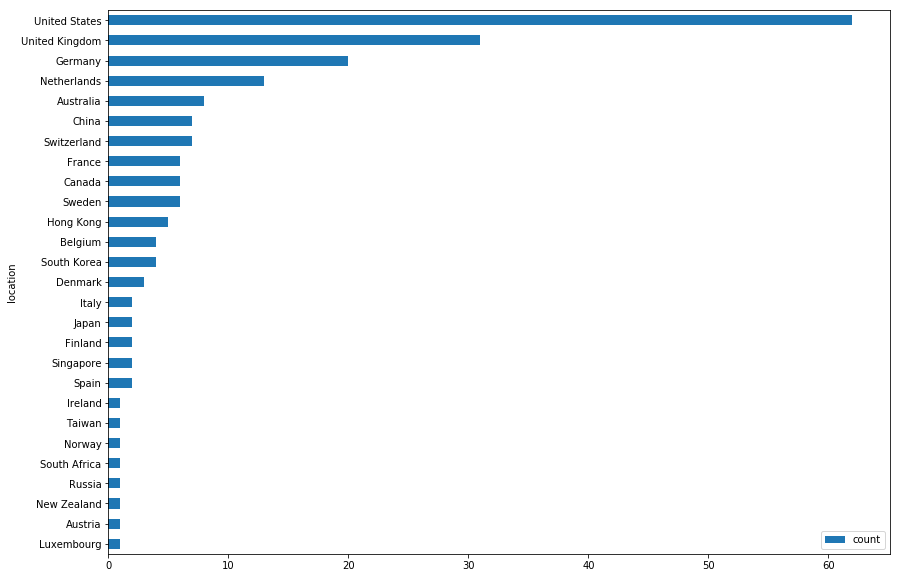

In [27]:
rank_country.sort_values('count', ascending=True).plot.barh(
    figsize=(14, 10),
)

In [28]:
rank_region = top200_times_df[['name', 'region']].groupby('region').count() \
                    .rename(columns={'name': 'count'}) \
                    .sort_values(by='count', ascending=False)
rank_region

,count
region,
Europe,101
North America,68
Asia,21
Oceania,9
Africa,1


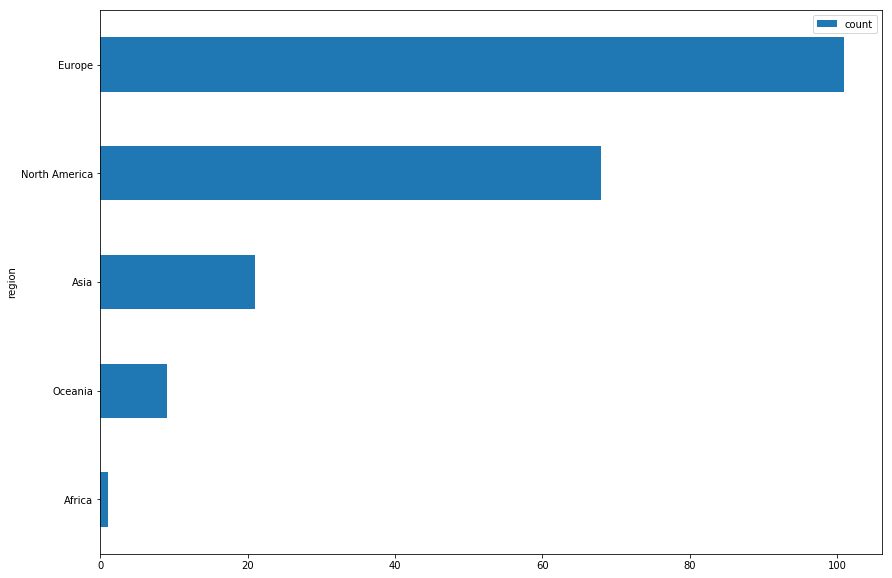

In [29]:
rank_region.sort_values('count', ascending=True).plot.barh(
    figsize=(14, 10),
)

Again, it would be interesting to check how the number of top Universites per region relates to the ratios.

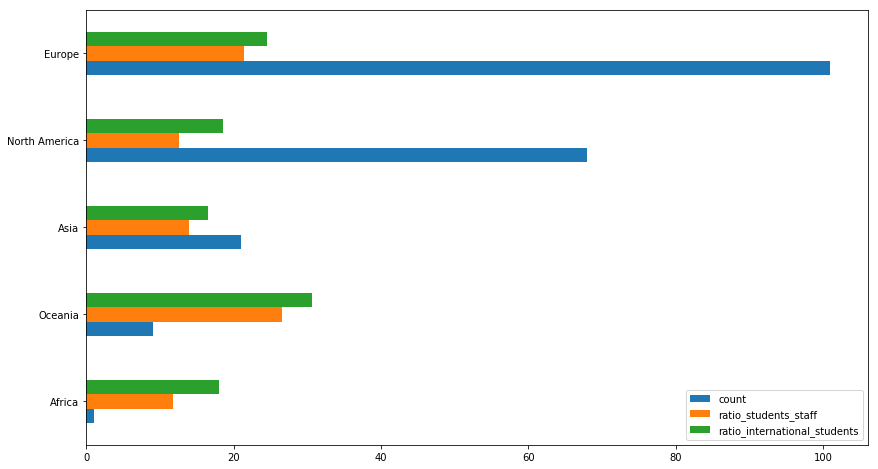

In [30]:
pd.concat([rank_region, region_ratio], axis=1).sort_values('count').plot.barh(
    figsize=(14, 8),
)

Again, we can observe that there is a quite strong relation between how many Universities from a given region are at the top-200 and the mean of the ratio of the international students. This is excepted, as top Universities, attract more students from abroad.

## Question 3

Merge the two DataFrames created in questions 1 and 2 using university names. Match universities' names as well as you can, and explain your strategy. Keep track of the original position in both rankings.

### Answer

Before we can merge the two `DataFrame`s, we need to normalise their columns names, i.e. make them common. For example, data from [topuniversities.com](topuniversities.com) refer to the country as "country", whereas data from [timeshighereducation.com](timeshighereducation.com) refer to country as "location".

In [31]:
columns = [
    'title',
    'rank',
    'country',
    'region',
    'staff_total',
    'staff_international',
    'students_total',
    'students_international',
    'ratio_students_staff',
    'ratio_international_students',
]

# topuniversities.com:
#   rank_display -> rank
top200_top_df.rename(columns={'rank_display': 'rank'}, inplace=True)
# drop all columns of non-interest
top200_top_df.drop(set(top200_top_df.columns) - set(columns), axis=1, inplace=True, errors='ignore')

# timeshighereducation.com:
#   name -> title
#   location -> country
top200_times_df.rename(columns={'name': 'title', 'location': 'country'}, inplace=True)
# drop all columns of non-interest
top200_times_df.drop(set(top200_times_df.columns) - set(columns), axis=1, inplace=True, errors='ignore')

Now that we have the data in a common format (i.e. identical column names and same semantics) in both `DataFrame`s, we should prepare for merging them. Since we want to merge on University titles (i.e. names), we have to make sure that University names are consistent between the two `DataFrame`s.

For this purpose, we shall make two passes on the University names.

On the first pass we shall use a string similarity metric and in particular [Levenshtein distance](https://en.wikipedia.org/wiki/Levenshtein_distance). For this purpose we use the [fuzzywuzzy](https://pypi.python.org/pypi/fuzzywuzzy) Python library. This step helps match 114 of the 200 University names.

First, we make the necessary imports and define the `similarity_ratio` function.

In [32]:
import itertools
import re
from fuzzywuzzy import fuzz

# calculate similarities among the University names
def similarity_ratio(x, y):
    """
    Given two strings x and y, find their similarity ratio.
    
    The algorithm is outlined below:
        1. Tokenize the two strings.
        2. Find the common tokens.
        3. Remove the common tokens from each of x and y and obtain xcomp and ycomp.
           This will result in differing tokens to have a greater impact on similarity drop.
        4. If either one of two strings remains empty, return the similarity ratio of the original strings (x, y),
           otherwise, return the similarity ratio of (xcomp, ycomp).
    """
    xtokens = set(x.replace('–', '').replace('-', '').split(' '))
    ytokens = set(y.replace('–', '').replace('-', '').split(' '))
    common_tokens = xtokens & ytokens  # set intersection
    # discard common tokens
    ytokens -= common_tokens
    xtokens -= common_tokens
    return fuzz.token_sort_ratio(' '.join(xtokens), ' '.join(ytokens)) if xtokens and ytokens else fuzz.ratio(x, y)

Then, we execute step 1 of string similarity.

In [33]:
# L contains tuples of three elements:
#   - tuple (i, x), where i is the index of name x in top200_top_df
#   - tuple (j, y), where j is the index of name y in top200_times_df
#   - value fuzz.partial_ratio(x, y), which is the similarity of x and y
L = {((i, x), (j, y), similarity_ratio(x, y))
     for (i, x), (j, y) in itertools.product(enumerate(top200_top_df['title']),
                                             enumerate(top200_times_df['title']))}
# keep in L1 only those names that have partial similarity ratio > 92%
L1 = set(filter(lambda x: x[2] > 92, L))

# we have decided to keep the names from topuniversities.com
# create two pandas.Series - we need those because University rank varies for each site
# s1 contains indexes from top200_top_df
s1 = pd.Series((t[1] for t, _, _ in L1), index=(t[0] for t, _, _ in L1))
# s2 contains indexes from top200_times_df
s2 = pd.Series((t[1] for t, _, _ in L1), index=(t[0] for _, t, _ in L1))

# remove the matched names from L
for elem in L1:
    (_, xx), (_, yy), _ = elem
    L = {((i, x), (j, y), v) for (i, x), (j, y), v in L if {xx, yy}.isdisjoint({x, y})}

`s1` and `s2` above contain the names matched from Step 1 of similarity match.

With 114 out of 200 names out of the way, we can now relax the similarity constraint to 78%.

This step helps match 32 further University names, bringing the total to 146.

In [34]:
# keep in L2 only those names that have partial similarity ratio > 78%
L2 = list(filter(lambda x: x[2] > 78, L))
L2 = sorted(L2, key=lambda x: x[2])
# s1 contains indexes from top200_top_df
s1 = s1.append(pd.Series((t[1] for t, _, _ in L2), index=(t[0] for t, _, _ in L2)), verify_integrity=True)
# s2 contains indexes from top200_times_df
s2 = s2.append(pd.Series((t[1] for t, _, _ in L2), index=(t[0] for _, t, _ in L2)), verify_integrity=True)

# remove the matched names from L
for elem in L2:
    (_, xx), (_, yy), _ = elem
    L = {((i, x), (j, y), v) for (i, x), (j, y), v in L if {xx, yy}.isdisjoint({x, y})}

With 146 out of 200 names out of the way, we can still match some more.

We run a 3rd step of similarity match, at this time with threshold 71%. This matches 3 more names, bringing the total to 149 matched names.

We manually add Trinity College Dublin and KAIST University, since their very different titles between the two sites keeps them from matching, thus we get a total of 151 out of 200 matchings.

In [35]:
# keep in L2 only those names that have partial similarity ratio > 71%
L3 = list(filter(lambda x: x[2] > 71, L))
L3.append((  # manually add Trinity College Dublin
    (87, 'Trinity College Dublin, The University of Dublin'),
    (117, 'Trinity College Dublin'), 63),
)
L3.append((  # manually add KAIST University
    (40, 'KAIST - Korea Advanced Institute of Science & Technology'),
    (95, 'Korea Advanced Institute of Science and Technology (KAIST)'), 71)
)
# s1 contains indexes from top200_top_df
s1 = s1.append(pd.Series((t[1] for t, _, _ in L3), index=(t[0] for t, _, _ in L3)), verify_integrity=True)
# s2 contains indexes from top200_times_df
s2 = s2.append(pd.Series((t[1] for t, _, _ in L3), index=(t[0] for _, t, _ in L3)), verify_integrity=True)

`s1` and `s2` are now two `pandas` `Series` containing University titles assignable to `top200_top_df` and `top200_times_df`, respectively.

We now have to replace the titles in each `DataFrame`.

In [36]:
# replace names in the respective DataFrames
top200_top_df['title'] = s1
top200_times_df['title'] = s2

We now drop the `NaN` titles from both `DataFrame`s. These are the titles that were not matched between the two rankings.

In [37]:
top200_top_df.dropna(subset=['title'], inplace=True)
top200_times_df.dropna(subset=['title'], inplace=True)

We also notice that in the "rank" column of the two dataframes, there are some values of the form "=number".
We want to remove the operator "=" from these values and keep clean numerical values, that will probably 
help us later, during our exploratory analysis.

In [38]:
top200_top_df['rank'] = top200_top_df['rank'].str.replace('=', '')
top200_times_df['rank'] = top200_times_df['rank'].str.replace('=', '')

We have now the two "clean" `DataFrame`s to work with.

We need to merge them in such a way that will make the exploratory analysis easy.

In [39]:
# make a copy of the two dataframes, just in case
top200_top_df_copy = top200_top_df.copy()
top200_times_df_copy = top200_times_df.copy()

top200_top_df_copy.set_index(['title'], inplace=True)
top200_times_df_copy.set_index(['title'], inplace=True)

# fill the missing international staff values for timeshighereducation.com data,
# by consulting the topuniversities.com data
top200_times_df_copy['staff_international'] = top200_top_df_copy['staff_international']

merged = pd.merge(top200_top_df_copy, top200_times_df_copy,
                  left_index=True, right_index=True, on=['country', 'region'],
                  suffixes=['@top', '@times'])

merged['rank@top'] = merged['rank@top'].astype(int)
merged['rank@times'] = merged['rank@times'].astype(int)

## Question 4

Find useful insights in the data by performing an exploratory analysis. Can you find a strong correlation between any pair of variables in the dataset you just created? Example: when a university is strong in its international dimension, can you observe a consistency both for students and faculty members?

### Answer

After going through the data, we found correlations among a University's ranking to some of the data variables that we previously extracted, as well as relations among the variables. We present those findings below.

#### 1. Dataset inconsistencies
In the underlining plots we observe that for the highest ranking universities, the count of timeshighereducation.com for staff_total is half compared to that of topuniversities.com.

This is also proved by the ratio of students/staff which differs significantly.

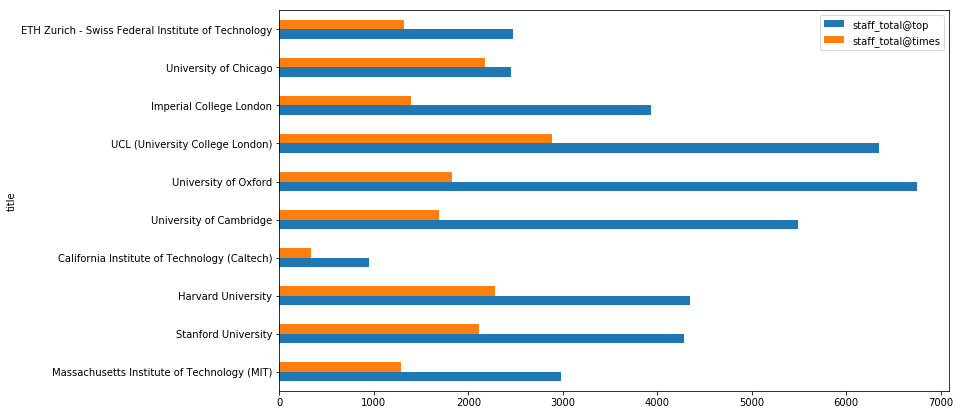

In [40]:
merged.sort_values('rank@top')[:10].plot(y=['staff_total@top', 'staff_total@times'],
        kind = 'barh', figsize=(12,7))

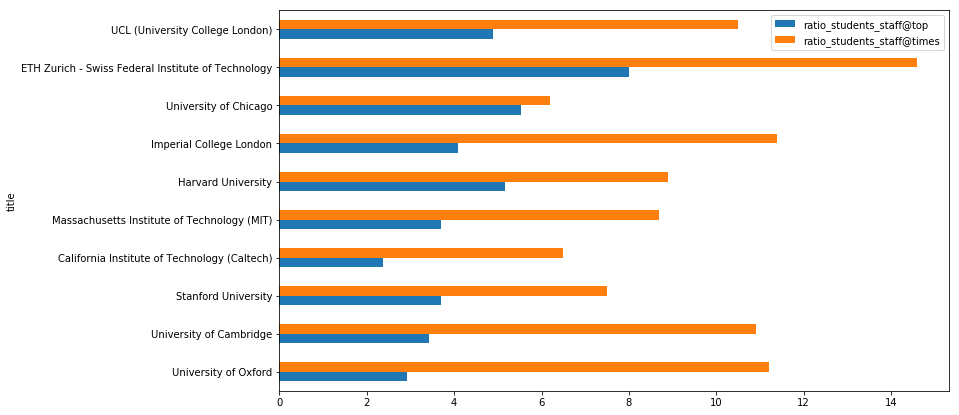

In [41]:
merged[:10].sort_values(by='rank@times')[:10].plot( 
        y=['ratio_students_staff@top', 'ratio_students_staff@times'],
        kind = 'barh', figsize=(12,7))

It seems that the two providers measure students in the same manner, but measure staff members differently.

This is illustrated in the plots above. In the first plot, the staff count provided by timeshighereducation.com is half than that of topuniversities.com, while in the second plot, the student/staff ratio provided by timeshighereducation.com is twice as big as the one provided by topuniversities.com. This indicates that while for the two websites, staff members are counted differently, on the other hand, students are counted more or less in the same way.

#### 2. International dimension

**(a) International students ratio and staff**

Let's take a look at the following plot.

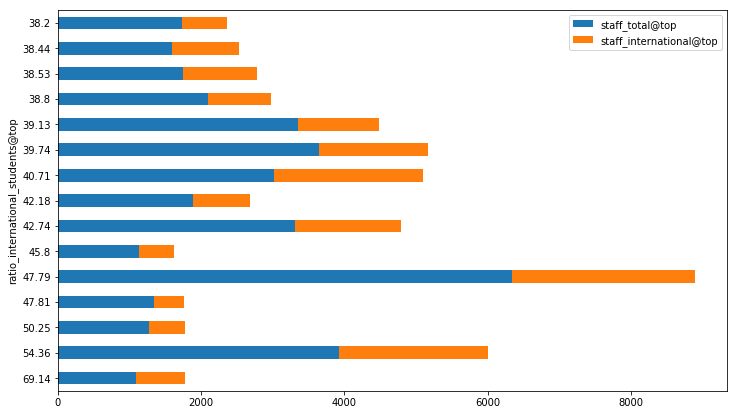

In [42]:
merged['ratio_international_students@top'] = merged['ratio_international_students@top'].apply(lambda x: round(x, 2))
merged.sort_values(by='ratio_international_students@top', ascending=False)[:15] \
      .plot(x='ratio_international_students@top',y=['staff_total@top', 'staff_international@top'],
            kind='barh', stacked=True, figsize=(12,7))

What we observe is that Universities that have a high international-to-total student ratio tend to also employ a high number of international staff as well (above 50% of total staff members, in general).

**(b) Ranking and international staff**

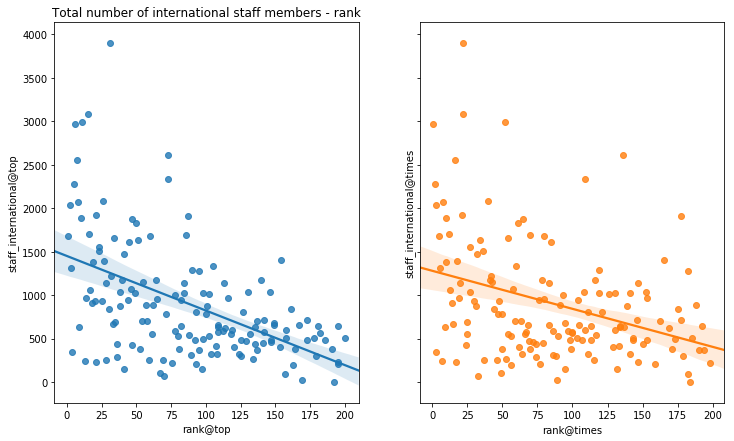

In [43]:
#Columns rank-staff_international

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True) 
fig.set_size_inches(12, 7)
sns.regplot(x='rank@top',y='staff_international@top', data=merged, fit_reg=True, ax=ax1) 
ax1.set_title('Total number of international staff members - rank')
sns.regplot(x='rank@times',y='staff_international@times', data=merged, fit_reg=True, ax=ax2)

We notice some correlation between the ranking of a university and the number of international staff members, in both plots. More specifically, the higher the rank of a university, the more its international staff members seem to be, based on both the data from the "top-universities" website and the data from the "times-higher-education" website. 

This correlation is somewhat expected, given that a well-known and highly-ranked university usually attracts scientists from all around the globe. It is also explained by the fact that the website "top-universities", uses the very criterion of "internationalization" (number of international students, number of international staff etc) as a means of ranking the universities. The interesting thing is, that the correlation also holds for the second plot, whose rank values come from the "times-higher-education" website, while the values of the column "staff_international" were actually transferred from the corresponding data of the "top-universities" website.

#### 3. Comparison between providers

We would also like to check how close the rankings of universities are, according to the two websites.

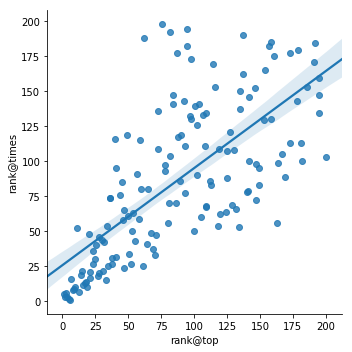

In [44]:
sns.lmplot(x='rank@top',y='rank@times',data=merged,fit_reg=True) 

What we observe is that while the rankings are strongly correlated, this is mainly due to the agreement of the first ~50 rankings. From that point on, the results start to diverge, which is an indication of the different approach each provider takes on their measurements. This also indicates that the best Universities are objectively very good, while in lower rankings the position is strongly affected by the subjective evaluation methods of each provider.

## Question 5

Can you find the best university taking in consideration both rankings? Explain your approach.

### Answer

While both providers take into account quite several measures to figure out a University's ranking, a lot of those measures are not available to us after the data extraction. So, we decided to come up with our own formula to decide the best University.

In [45]:
def evaluate(x):
    variable_coeffs = {
        'rank@top': 0.15,
        'rank@times': 0.15,
        'ratio_international_students@top': 0.15,
        'ratio_international_students@times': 0.15,
        'ratio_students_staff@top': 0.20,
    }
    s = sum([x[v] * coeff for (v, coeff) in variable_coeffs.items()]) + (1/x['staff_international@top'] * 0.2)
    return s

results = merged.apply(evaluate, axis=1)
results.sort_values().head(20)

title
Stanford University                              8.202246
Harvard University                               9.803592
California Institute of Technology (Caltech)     9.875152
Yale University                                 10.837938
University of Pennsylvania                      11.188497
University of Chicago                           11.296038
Princeton University                            11.535436
Massachusetts Institute of Technology (MIT)     11.780378
University of Cambridge                         12.337465
University of Michigan                          12.585289
Tsinghua University                             12.601211
Johns Hopkins University                        12.636685
Duke University                                 12.846070
University of Oxford                            12.927259
Northwestern University                         13.529420
Cornell University                              13.867206
University of California, Berkeley (UCB)        13.996754
Universi

Our formula is the following:

    R = rank1 * 0.15 + rank2 * 0.15
        + inter_student_ratio_1 * 0.15 + inter_student_ratio_2 * 0.15
        + student_staff_ratio * 0.20
        + (1 / staff_international) * 0.2

The reasoning behind this formula is the following:
* We take rank positions into account with a relatively small coefficient, 15% for each ranking. This is to minimise the effect the position has on our decision, as it is dependent to the provider's subjective criteria.
* We take international student ratio into account by 15% from each provider. This is one of the most consistent data that we have and is important for a University's international dimension.
* We take the student-to-staff ratio into account with a coefficient of 20%, from topuniversities.com. This is because the two providers measure staff members differently, so we chose to trust the first provider.
* Finally, we take international staff ratio into account with a coefficient of 20%. This is maybe the most important variable, as high stature Universities are more likely to attract international staff.

The best University (according to our criteria) would be the one with the lowest `R` value. Sorry, EPFL...